TODO:
- Scale real and synthetic differently
- Look at LBM paper for error
- Create data generator
- Add evaluation of validation data

In [1]:
from __future__ import division

from utils import *
from prep_data import *

import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime
from datetime import date
from datetime import timedelta
from dateutil.parser import parse

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# from ggplot import *

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras import backend as K

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_TEST = [2,9,20]
HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model, 'train_dts.npy'))

In [5]:
take_diff = False
val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]

In [6]:
# In every set of data, there's a feature set X, targets Y, and extra features
# regarding house number and date that can be used to subset or diagnose.
# This data will be saved as a package according to the order below. This makes
# it easier to enter into functions like train_test_split() and shuffle() using
# *kwargs.
X_idx = 0
Y_idx = 1
x_house_idx = 2
x_date_idx = 3

In [52]:
def show_data_dims(all_data):
    for key in all_data.keys():
        print key
        for dat in all_data[key]:
            print dat.shape

In [7]:
# Run this once.

# Split real data into train and val/test (same dataset for now).
all_data = OrderedDict()
all_data['real'] = load_real_data(dir_for_model_real)
# print all_data['real']
train_mask_real = (np.in1d(all_data['real'][x_date_idx], train_dates)) & (np.in1d(all_data['real'][x_house_idx], HOUSE_IDS_TRAIN_VAL))
n_train_real = all_data['real'][X_idx][train_mask_real].shape[0]
print 'obs for train/val: {} ({:0.2g}% of total)'.format(n_train_real,
                                                         n_train_real / all_data['real'][X_idx].shape[0] * 100)
all_data['real_train'] = []
all_data['val_test'] = []  # test doesn't take synthetic data, so don't need "real_" suffix
for dat in all_data['real']:
    all_data['real_train'].append(dat[train_mask_real])
    all_data['val_test'].append(dat[~train_mask_real])
del all_data['real']

show_data_dims(all_data)

obs for train/val: 5273 (70% of total)
real_train
(5273, 14400)
(5273, 5)
(5273,)
(5273,)
val_test
(2275, 14400)
(2275, 5)
(2275,)
(2275,)


In [8]:
# Split real val/test into val and test. Split 50-50.
real_data_split = train_test_split(*all_data['val_test'],
                                   test_size=0.5,
                                   stratify=all_data['val_test'][x_house_idx])
all_data['val'] = real_data_split[::2]
all_data['test'] = real_data_split[1::2]
del all_data['val_test']

show_data_dims(all_data)

real_train
(5273, 14400)
(5273, 5)
(5273,)
(5273,)
val
(1137, 14400)
(1137, 5)
(1137,)
(1137,)
test
(1138, 14400)
(1138, 5)
(1138,)
(1138,)


1
2013-10-17


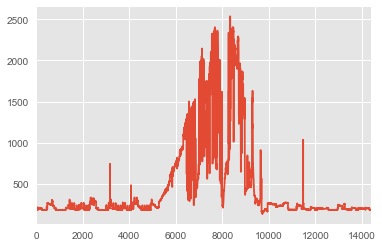

In [13]:
plt.close()
tmp = all_data['real_train']
for x, x_house, x_date in zip(tmp[X_idx][[7]], tmp[x_house_idx], tmp[x_date_idx][[7]]):
    print x_house
    print x_date
    plot_series(x)
    plt.show()

In [49]:
# get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
# load_app, load_ts, load_issues = create_load_funs(dir_refit)
    
# dir_refit = os.path.join(dir_data, 'refit')
# path_apps = os.path.join(dir_data, 'appliances.csv')
# apps = pd.read_csv(path_apps)
# app_dict = create_app_dict()
# apps = apps_add_cols_from_patterns(apps, app_dict)
    

# def load_ts(house_id):
#     return np.load(os.path.join(dir_refit,
#                                 'house{}'.format(house_id),
#                                 'Unix.npy'))

# def get_df(house_id, use_app_names=False, dt_start=None, dt_end=None, include_issues=False):
#     '''
#     Plot time series of power data for each appliance, for specified house and date(time).
#     '''

#     # Load time series for house and get timestamps for specified date.
#     ts_series = load_ts(house_id)

#     # Add first column to df (timestamp).
#     df = pd.DataFrame({'Unix': ts_series})

#     # Add appliance columns.
#     for app_num in range(10):
#         if use_app_names:
#             app_name = get_app_name(house_id, app_num)
#         else:
#             app_name = 'Appliance{}'.format(app_num) if app_num>0 else 'Aggregate'
#         df[app_name] = load_app(house_id, app_num)

#     if dt_start is not None:  # that is, if we don't want all dates
#         ts_mask = get_ts_mask(ts_series, dt_start, dt_end)
#         df = df.loc[ts_mask]

#     if include_issues:
#         # Add issues column.
#         df['Issues'] = load_issues(house_id)

#     return df


# def get_app_name(house_id, app_num):
#     return apps[(apps['House'] == house_id) & (apps['ApplianceNum'] == app_num)]['Appliance'].values[0]
    
# def plot_day(house_id, dt, savefile=None, figsize=(9,5), cols=None):
#     '''
#     Plot time series of power data for each appliance, for specified house and date(time).
#     '''
#     df = get_df(house_id, use_app_names=True, dt_start=dt)
#     if cols is not None:
#         cols += ['Unix']  # add Unix in case it wasn't included in cols
#         cols = list(set(cols))
#         df = df[cols]
#     df['Time'] = pd.to_datetime(df['Unix'], unit='s', utc=True)
#     df.set_index('Time', inplace=True)
#     del df['Unix']

#     # df = df.tz_localize('GMT').tz_convert('Europe/London')
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     app_names = list(df)  # get columns from DataFrame

#     # Set color map.
#     colormap = plt.cm.Set1
#     ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
#     # ax = df.plot(figsize=figsize)
#     for app_name in app_names:
#         ax = df[app_name].plot(figsize=figsize)
#     ax.set_title('House {}\n{}'.format(house_id, dt.date().strftime('%Y-%m-%d')))
#     ax.set_xlabel('')
#     ax.set_ylabel('Power (Watts)')
#     # plt.xticks(np.arange(min(df.index), max(df.index)+1, 8.))

#     # Put legend outside of plot.
#     # https://stackoverflow.com/a/4701285/4794432
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#     # # Decrese legend font size.
#     # fontP = FontProperties()
#     # fontP.set_size('xx-small')

#     if savefile is not None:
#         plt.savefig(savefile)
#     return ax

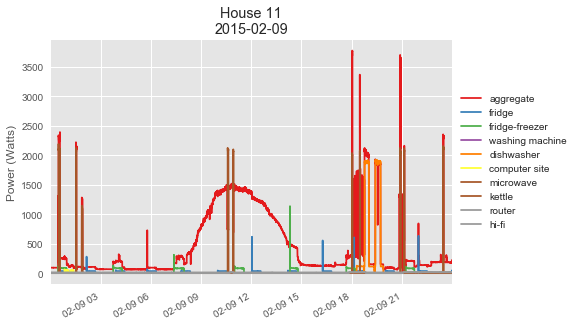

In [92]:
plot_day(11, datetime(2015,2,9))

In [50]:
# Load all synthetic training data.
all_data['synth_train_all'] = load_synth_data(dir_for_model_synth)

In [51]:
# Create scalers for real and synthetic (mean only since they have different means).
scaler_real = StandardScaler(with_std=False).fit(all_data['real_train'][X_idx].reshape(-1,1))
scaler_synth = StandardScaler(with_std=False).fit(all_data['synth_train_all'][X_idx].reshape(-1,1))

# Create scaler for combined real and synthetic (standard dev only
# to retain difference in power between timesteps). Sample synthetic
# so that there are the same number of obs for real and synthetic.
sample_idx = np.random.choice(all_data['synth_train_all'][X_idx].shape[0], n_train_real, replace=False)
train_dat = np.concatenate((all_data['synth_train_all'][X_idx][sample_idx],
                            all_data['real_train'][X_idx]))
scaler_both = StandardScaler(with_mean=False).fit(train_dat.reshape(-1,1))
del train_dat

/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


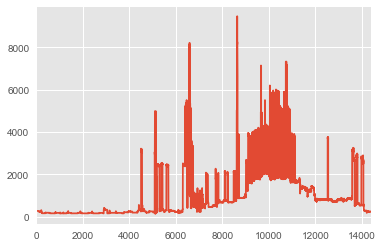

In [61]:
for tmp in all_data['val'][X_idx][:3]:
    plt.close()
    plot_series(tmp)
    plt.plot()

In [12]:
# Scale validation and test data.
for split_type in ['val', 'test']:
    all_data[split_type][X_idx] = scaler_real.transform(all_data[split_type][X_idx])
    all_data[split_type][X_idx] = scaler_both.transform(all_data[split_type][X_idx])

X_val, Y_val, x_house_val, x_date_val = all_data['val']  # can extract these now for easier reference
X_test, Y_test, x_house_test, x_date_test = all_data['test']  # can extract these now for easier reference

{1, 4, 5, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19}

In [14]:
# for x in X_val[:10]:
#     plot_series(x)
#     plt.show()

In [15]:
# plt.close()
# for x in all_data['val'][X_idx][-10:]:
#     plot_series(x)
#     plt.show()

In [13]:
# Run this every epoch.

# Create training data.

# Randomly grab some of the synthetic data for training,
# making sure it's the same size as the real data. Ignore
# the rest of the split.
all_data['synth_train'] = train_test_split(
    *all_data['synth_train_all'],
    train_size=n_train,
    stratify=all_data['synth_train_all'][x_house_idx],  # by house
    random_state=None)[::2]  # takes the first of the output pairs, which has same # obs as real train

all_data['train'] = []
for i, (r, s) in enumerate(zip(all_data['real_train'], all_data['synth_train'])):
    
    if i == X_idx:
        # Scale mean of real and synthetic series separately since levels of real is higher.
        r = scaler_real.transform(r)
        s = scaler_synth.transform(s)
        
    all_data['train'].append(np.concatenate((r, s)))

del all_data['synth_train']
 
# Now scale combined real/synthetic power series by std.
all_data['train'][X_idx] = scaler_both.transform(all_data['train'][X_idx])    

# Mix up real and synth obs.
all_data['train'] = shuffle(*all_data['train'], random_state=None)

In [14]:
# tmp = np.array([[1, 2, 4], [4, 5, 7]])
# print tmp
# tmp = scaler_real.transform(tmp)
# print tmp
# plt.close()
# for tmp1 in all_data['train'][0]:
#     plot_series(tmp1)
#     plt.show()

In [15]:
for key in all_data.keys():
    print key
    for dat in all_data[key]:
        print dat.shape

test
(2444, 14400)
(2444, 5)
(2444,)
(2444,)
real_train
(4084, 14400)
(4084, 5)
(4084,)
(4084,)
synth_train_all
(49880, 14400)
(49880, 5)
(49880,)
(49880,)
val
(2040, 14400)
(2040, 5)
(2040,)
(2040,)
train
(8168, 14400)
(8168, 5)
(8168,)
(8168,)


In [16]:
X_train, Y_train, x_house_train, x_date_train = all_data['train']

In [17]:
# Choose an appliance to model.

# y = Y[:,0]  # fridge
Y_train = all_data['train'][Y_idx]
y_train = [Y_train_row[0] for Y_train_row in Y_train]  # fridge
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)

In [24]:
# Preprocss.

# Take first-difference (if desired).
if take_diff:
    
    # Training data.
    X_train = np.diff(X_train)
    zs_train = np.zeros((X_train.shape[0], 1), dtype=int)
    X_train = np.concatenate((zs_train, X_train), axis=1)  # pad beginning with zeros to preserve shape
    
    # Validation data.
    X_val = np.diff(X_val)
    zs_val = np.zeros((X_val.shape[0], 1), dtype=int)
    X_val = np.concatenate((zs_val, X_val), axis=1)

In [25]:
# Reshape as tensor.
image_data_format = K.image_data_format()  # 'channels_last'
if image_data_format == 'channels_last':
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    input_shape = (N_PER_DAY, 1)
elif image_data_format == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    input_shape = (1, N_PER_DAY)
else:
    raise ValueError

In [26]:
kernel_size = 3
strides = 1
start_filters = 8
pool_size = 2

model = Sequential()
model.add(Conv1D(start_filters,
                 kernel_size,
                 strides=strides,
                 activation='relu',
                 input_shape=input_shape,
                 padding='same'))
model.add(MaxPooling1D(pool_size, padding='same'))
model.add(Conv1D(start_filters*2, kernel_size, strides=strides, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size, padding='same'))
# model.add(Conv1D(start_filters*2**2, kernel_size, strides=strides, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softplus'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse', 'mae', 'mape'])

In [23]:
# def dist_fun(y, min_y=None, inverse=False):
#     if min_y is None and not inverse:
#         min_y = min(y)
#         return (1/(y - min_y + 1), min_y)
#     elif min_y is not None and inverse:
#         return 1/y + min_y - 1
#     else:
#         raise ValueError

# def dist_fun(y):
#     return y
        
# # sns.distplot(y)
# # y_inv, min_y = dist_fun(y)
# # y_recovered = dist_fun(y_inv, min_y=min_y, inverse=True)
# # print y[:3]
# # print y_recovered[:3]
# # sns.distplot(dist_fun(y_inv, min_y=min_y, inverse=True))

In [27]:
# DID NOT TAKE DIFFS OF X

print type(X_train), X_train.shape
print type(y_train), y_train.shape

history = model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.2)

<type 'numpy.ndarray'> (8168, 14400, 1)
<type 'numpy.ndarray'> (8168, 1)
Train on 6534 samples, validate on 1634 samples
Epoch 1/3
6534/6534 [==============================] - 85s - loss: 0.3803 - mean_squared_error: 0.3803 - mean_absolute_error: 0.4757 - mean_absolute_percentage_error: 92755032.7596 - val_loss: 0.2863 - val_mean_squared_error: 0.2863 - val_mean_absolute_error: 0.4149 - val_mean_absolute_percentage_error: 76536136.7375

['loss', 'val_mean_absolute_percentage_error', 'mean_absolute_percentage_error', 'val_mean_squared_error', 'val_mean_absolute_error', 'mean_squared_error', 'val_loss', 'mean_absolute_error']


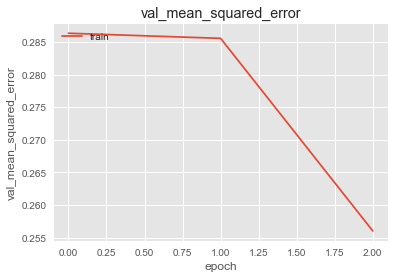

In [29]:
print(history.history.keys())
# summarize history for mse
plt.plot(history.history['val_mean_squared_error'])
plt.title('val_mean_squared_error')
plt.ylabel('val_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# loss_and_metrics = model.evaluate(X, y, )
y_hat = model.predict(X_train)
# Y_hat = model.predict(X)

In [31]:
# print np.argwhere(y_hat > 5)
# y_hat[1643]

# https://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python

def plot_empir_cum(x):
    return plt.step(sorted(x), np.arange(len(x))/len(x), color='black')

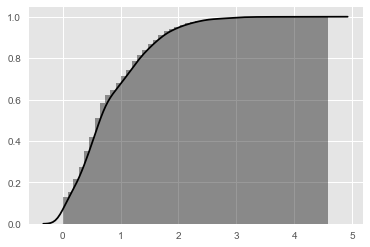

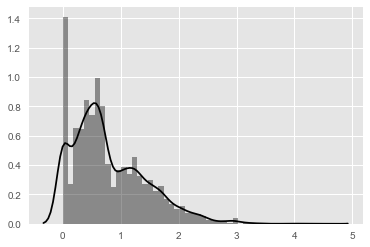

In [33]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')
sns.distplot(y_train, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(y_train, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show() 

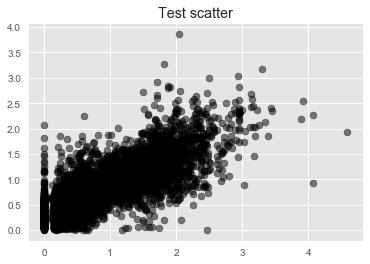

In [34]:
# # y_hat = dist_fun(y_hat, min_y, True)
# ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat), color='black')
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)

fig = plt.figure()
ax = fig.add_subplot(111, title="Test scatter")
ax.scatter(y_train, y_hat, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
plt.show()
# print min(y_hat)


# i = 3
# y, y_hat = Y[:,i], Y_hat[:,i]
# fig = plt.figure()
# ax = fig.add_subplot(111, title='Test scatter')
# ax.scatter(y_hat, y, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
# # print min(y_hat)